In [30]:
from sys import path
path.append('..')
path.append('../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join

from sklearn.metrics import accuracy_score

from keras.applications import MobileNet
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Flatten, GlobalAvgPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from skmultilearn.model_selection import iterative_train_test_split

from global_config import RANDOM_SEED, IMAGE_SIZE, FILE_DUMP_IMAGES, FILE_DUMP_MRKS
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from utils import plot, load

%matplotlib inline

In [2]:
PATH_TO_ROOT = '../'
FILE_SAMPLES = "data/baseline_samples.pkl"
FOLDER_MODELS = "models/baselines/"

FILE_SAMPLES = join(PATH_TO_ROOT, FILE_SAMPLES)
FILE_DUMP_MRKS = join(PATH_TO_ROOT, FILE_DUMP_MRKS)
FILE_DUMP_IMAGES = join(PATH_TO_ROOT, FILE_DUMP_IMAGES)
FILE_FEATURES_TRAIN = join(PATH_TO_ROOT, "data/baseline_features_train.pkl")
FILE_FEATURES_VALID = join(PATH_TO_ROOT, "data/baseline_features_valid.pkl")
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)

print(FILE_SAMPLES)
print(FILE_DUMP_MRKS)
print(FILE_DUMP_IMAGES)
print(FILE_FEATURES_TRAIN)
print(FILE_FEATURES_VALID)
print(FOLDER_MODELS)

../data/baseline_samples.pkl
../data/cropped_faces/cropped_faces_mrks.pkl
../data/cropped_faces/cropped_faces_images.pkl
../data/baseline_features_train.pkl
../data/baseline_features_valid.pkl
../models/baselines/


In [3]:
INPUT_SHAPE = (*IMAGE_SIZE, 3)
N_REQS = 23
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Baselines'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)


def save_bottleneck_features(model, x, output_file):
    features = model.predict(x, verbose=1)
    pkl.dump(features, open(output_file, 'wb'), protocol=-1)

# Data Loading 

In [5]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))
y = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])

print(x.shape, x.dtype)
print(y.shape, y.dtype)
print(len(mrks))

(5731, 160, 160, 3) float32
(5731, 23) int32
5731


In [6]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train, x_val_idx, y_val = iterative_train_test_split(
    np.arange(x.shape[0]).reshape(-1, 1), 
    y, 
    test_size=TEST_SIZE
)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5151, 160, 160, 3) (5151, 23)
(580, 160, 160, 3) (580, 23)


In [7]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

# pkl.dump((x_train, y_train, x_val, y_val, train_mrks, val_mrks), open(FILE_SAMPLES, 'wb'), -1)

In [8]:
x_train, y_train, x_val, y_val, _, _ = pkl.load(open(FILE_SAMPLES, "rb"))
x_train /= 255.0
x_val /= 255.0

print(x_train.shape, x_train.dtype, x_train.min(), x_train.max())
print(y_train.shape, y_train.dtype, y_train.min(), y_train.max())
print(x_val.shape, x_val.dtype, x_val.min(), x_val.max())
print(y_val.shape, y_val.dtype, y_val.min(), y_val.max())

(5151, 160, 160, 3) float32 0.0 1.0
(5151, 23) int32 0 1
(580, 160, 160, 3) float32 0.0 1.0
(580, 23) int32 0 1


# Save Bottlenecks 

In [9]:
base_model = MobileNet(input_shape=INPUT_SHAPE, weights="imagenet", include_top=False)

save_bottleneck_features(base_model, x_train, FILE_FEATURES_TRAIN)
save_bottleneck_features(base_model, x_val, FILE_FEATURES_VALID)

Instructions for updating:
Colocations handled automatically by placer.
580/580 [==============================] - 22s 38ms/step


# Model Training 

In [10]:
features_train = pkl.load(open(FILE_FEATURES_TRAIN, "rb"))
features_valid = pkl.load(open(FILE_FEATURES_VALID, "rb"))

print(features_train.shape, features_train.dtype)
print(features_valid.shape, features_valid.dtype)

(5151, 5, 5, 1024) float32
(580, 5, 5, 1024) float32


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
outputs (Dense)              (None, 23)                23575     
Total params: 23,575
Trainable params: 23,575
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 5151 samples, validate on 580 samples
Epoch 1/100
5151/5151 [==============================] - 1s 150us/step - loss: 0.3546 - accuracy: 0.8440 - precision: 0.8683 - recall: 0.9489 - f1: 0.9061 - fbeta: 0.9282 - specificity: 0.4265 - negative_predictive_value: 0.6885 - matthews_correlation_coefficient: 0.4558 - val_loss: 0.2561 - val_accuracy: 0.9004 - val_precision: 0.9057 - val_recall: 0.9617 - val_f1: 0.9320 - val_fbeta: 0.9485 - val_specificity: 0.

5151/5151 [==============================] - 0s 93us/step - loss: 0.1845 - accuracy: 0.9252 - precision: 0.9364 - recall: 0.9724 - f1: 0.9540 - fbeta: 0.9636 - specificity: 0.7374 - negative_predictive_value: 0.8702 - matthews_correlation_coefficient: 0.7563 - val_loss: 0.1900 - val_accuracy: 0.9292 - val_precision: 0.9310 - val_recall: 0.9723 - val_f1: 0.9506 - val_fbeta: 0.9629 - val_specificity: 0.7683 - val_negative_predictive_value: 0.8886 - val_matthews_correlation_coefficient: 0.7785

Epoch 00013: val_fbeta did not improve from 0.96319
Epoch 14/100
5151/5151 [==============================] - 0s 95us/step - loss: 0.1818 - accuracy: 0.9263 - precision: 0.9379 - recall: 0.9722 - f1: 0.9547 - fbeta: 0.9638 - specificity: 0.7440 - negative_predictive_value: 0.8708 - matthews_correlation_coefficient: 0.7607 - val_loss: 0.1879 - val_accuracy: 0.9300 - val_precision: 0.9314 - val_recall: 0.9746 - val_f1: 0.9519 - val_fbeta: 0.9647 - val_specificity: 0.7672 - val_negative_predictive_val

5151/5151 [==============================] - 0s 97us/step - loss: 0.1575 - accuracy: 0.9369 - precision: 0.9477 - recall: 0.9749 - f1: 0.9610 - fbeta: 0.9682 - specificity: 0.7854 - negative_predictive_value: 0.8871 - matthews_correlation_coefficient: 0.7964 - val_loss: 0.1858 - val_accuracy: 0.9318 - val_precision: 0.9346 - val_recall: 0.9695 - val_f1: 0.9511 - val_fbeta: 0.9612 - val_specificity: 0.7865 - val_negative_predictive_value: 0.8828 - val_matthews_correlation_coefficient: 0.7855

Epoch 00027: val_fbeta did not improve from 0.96527
Epoch 28/100
5151/5151 [==============================] - 1s 100us/step - loss: 0.1564 - accuracy: 0.9375 - precision: 0.9488 - recall: 0.9743 - f1: 0.9613 - fbeta: 0.9679 - specificity: 0.7912 - negative_predictive_value: 0.8853 - matthews_correlation_coefficient: 0.7988 - val_loss: 0.1888 - val_accuracy: 0.9306 - val_precision: 0.9367 - val_recall: 0.9662 - val_f1: 0.9507 - val_fbeta: 0.9593 - val_specificity: 0.7960 - val_negative_predictive_va

5151/5151 [==============================] - 0s 93us/step - loss: 0.1440 - accuracy: 0.9428 - precision: 0.9535 - recall: 0.9759 - f1: 0.9646 - fbeta: 0.9704 - specificity: 0.8097 - negative_predictive_value: 0.8943 - matthews_correlation_coefficient: 0.8159 - val_loss: 0.1901 - val_accuracy: 0.9310 - val_precision: 0.9391 - val_recall: 0.9643 - val_f1: 0.9508 - val_fbeta: 0.9580 - val_specificity: 0.8061 - val_negative_predictive_value: 0.8661 - val_matthews_correlation_coefficient: 0.7870

Epoch 00041: val_fbeta did not improve from 0.96527
Epoch 42/100
5151/5151 [==============================] - 0s 96us/step - loss: 0.1431 - accuracy: 0.9435 - precision: 0.9537 - recall: 0.9768 - f1: 0.9650 - fbeta: 0.9711 - specificity: 0.8110 - negative_predictive_value: 0.8981 - matthews_correlation_coefficient: 0.8189 - val_loss: 0.1916 - val_accuracy: 0.9316 - val_precision: 0.9405 - val_recall: 0.9656 - val_f1: 0.9521 - val_fbeta: 0.9595 - val_specificity: 0.8102 - val_negative_predictive_val

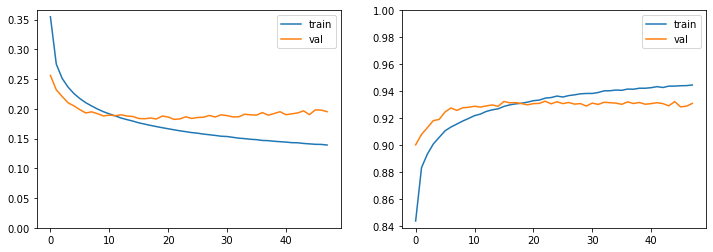

In [11]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.keras.autolog()

set_random_seeds()

metrics = ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc]
METRIC_TO_MONITOR = "val_fbeta"

model = Sequential([
    GlobalAvgPool2D(input_shape=features_train.shape[1:]),
    Dense(units=N_REQS, activation="sigmoid", name="outputs")
])
model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f"baseline_{base_model.name}_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode="max", verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode="max", patience=30, verbose=1, restore_best_weights=True)
]

hist = model.fit(
    x=features_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(features_valid, y_val),
    callbacks=list_callbacks
)

plot.keras_hist(hist.history)
mlflow.end_run()

# Final Model 

In [23]:
base_model = MobileNet(input_shape=INPUT_SHAPE, weights="imagenet", include_top=False)
last_layer = model.layers[-1]

x = GlobalAvgPool2D()(base_model.output)
outputs = Dense(units=N_REQS, activation="sigmoid", name="outputs")(x)

final_model = Model(inputs=base_model.input, outputs=outputs)
final_model.layers[-1].set_weights(last_layer.get_weights())
final_model.summary()

final_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 161, 161, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128 

In [34]:
features_sample = features_valid[0]
features_sample = features_sample.reshape((1, *features_valid.shape[1:]))

y_model = model.predict(features_sample)
print(y_model)

[[0.9837128  0.98599946 0.9998938  0.09423116 0.99054134 0.9999987
  0.9995118  0.9885322  0.9990405  0.05395192 0.18719178 0.19993332
  0.99938494 0.55626994 0.70551354 0.9999993  0.8277309  0.9999995
  0.96463025 0.99321437 0.9990238  0.92399687 0.9998416 ]]


In [35]:
x_sample = x_val[0]
x_sample = x_sample.reshape((1, *x_val.shape[1:]))

y_final = final_model.predict(x_sample)
print(y_final)

[[0.9837128  0.9859995  0.99989384 0.09423098 0.9905413  0.99999875
  0.9995117  0.9885323  0.9990405  0.05395216 0.18719208 0.19993317
  0.999385   0.5562714  0.7055142  0.9999993  0.8277305  0.9999995
  0.96463037 0.99321425 0.9990238  0.92399687 0.9998416 ]]


In [38]:
assert np.allclose(y_model, y_final)

In [39]:
y_model = model.predict(features_valid)
y_model = np.where(y_model >= 0.5, 1, 0)

y_final = final_model.predict(x_val, verbose=1)
y_final = np.where(y_final >= 0.5, 1, 0)

acc_model = accuracy_score(y_model, y_val)
acc_final = accuracy_score(y_final, y_val)

print(acc_model)
print(acc_final)
assert np.isclose(acc_model, acc_final)

580/580 [==============================] - 19s 33ms/step
0.25
0.25


In [40]:
final_model.save(FILE_MODEL)

In [41]:
print(FILE_MODEL)

../models/baselines/baseline_mobilenet_1.00_160_2021_06_26-23_43_51.h5


In [45]:
val_mrks[0].filepath

'..\\data/cropped_faces/ground_truth/afwDB_0.mrk'